In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from functools import partial

In [2]:
def distance_weighted(x, y, mu, eps=1e-3):
    if np.abs(np.sum(mu) - 1) > eps:
        raise ValueError("mu must sum to 1")
    return np.sum(np.array(mu) * (x - y) ** 2)

### Preprocessing

In [3]:
import pandas as pd
train_data = pd.read_csv('data/BATADAL/BATADAL_dataset04.csv')

In [4]:
train_data[" ATT_FLAG"].value_counts()
df_np_label = train_data.drop(["DATETIME", " ATT_FLAG"], axis=1).values


In [5]:
def generate_subsequences(data, window_size, step_size):
    num_points, num_variables = data.shape
    number_subs = int((num_points - window_size)/step_size) + 1  # Number of subsequences

    subsequences = np.zeros((number_subs, window_size, num_variables))

    for i in range(number_subs):
        subsequences[i, :, :] = data[i*step_size:i*step_size+window_size, :]
    return subsequences

def reconstructed_loss(reconstructed_points, initial_points):
    return np.linalg.norm(reconstructed_points - initial_points, ord=2, axis=1)


In [6]:
window_size = 10
stride = 5
sequences = generate_subsequences(df_np_label, window_size, stride)
label_sequences = generate_subsequences(
    train_data[" ATT_FLAG"].values.reshape(-1, 1), window_size, stride
)

In [7]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
mu = [1 / data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering.T,
    2, # N cluster
    2, # jsp
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [8]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)


In [9]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

# fig.add_trace(
#     go.Scatter(
#         x=train_data.index,
#         y=train_data[" ATT_FLAG"],
#         mode="markers",
#         name="True Attack",
#     )
# )

fig

### Optimization

In [11]:
# !pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga

In [24]:
def objective_function(data_for_clustering: np.ndarray, list_mu: np.ndarray):
    # list_mu shape = dim

    win_len = data_for_clustering.shape[1] // len(list_mu)

    mu = np.repeat(list_mu, win_len)
    mu = mu / mu.sum()  # normalize the coefficients

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data_for_clustering.T,
        3,
        2,
        metric=partial(distance_weighted, mu=mu),
        error=0.005,
        maxiter=1000,
        init=None,
    )

    # Reconstruction of initial points
    reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]
    loss = reconstructed_loss(reconstructed_points, data_for_clustering)

    return loss.sum()

In [25]:
dim = data_for_clustering.shape[1] // window_size

In [26]:
objective_function(
    data_for_clustering,
    np.array([1 / data_for_clustering.shape[1] for i in range(dim)]),
)

145686.2190214533

In [27]:
varbound = np.array([[0, 1]] * dim)

In [29]:
algorithm_param = {
    "max_num_iteration": 20,
    "population_size": 100,
    "mutation_probability": 0.1,
    "elit_ratio": 0.01,
    "crossover_probability": 0.5,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None,
}

 The best solution found:                                                                           
 [1.19225181e-02 3.81744655e-01 2.81669094e-02 3.46277258e-01
 7.21033820e-01 4.35685822e-01 5.61838208e-04 1.06186998e-01
 5.98189324e-01 7.43774604e-01 4.43166964e-01 9.30069727e-02
 4.53998414e-01 8.87624883e-01 3.31093243e-01 1.25990924e-01
 5.33379632e-01 8.08478990e-01 3.28461324e-01 5.63792927e-01
 9.07519264e-01 8.04836559e-01 6.25256457e-01 2.99406512e-01
 8.02046610e-01 8.28582192e-01 5.70266925e-01 7.00717935e-03
 8.94042352e-01 1.39688127e-01 4.45357792e-01 5.97482049e-01
 1.78468966e-02 9.92029283e-01 3.32263473e-01 3.02463905e-01
 7.39348298e-02 9.53223772e-01 1.51474902e-01 4.91286991e-01
 1.28519835e-01 2.60060045e-02 5.62240315e-01]

 Objective function:
 141805.45839234657


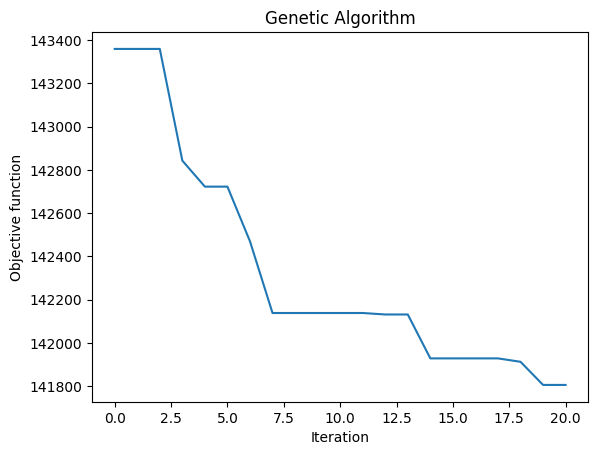

In [30]:
model = ga(
    function=partial(objective_function, data_for_clustering),
    dimension=dim,
    variable_type="real",
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param,
    function_timeout=100,
)

model.run()

In [32]:
convergence = model.report
solution = model.output_dict

In [ ]:
# naive : 153995.66723152378

In [33]:
solution

{'variable': array([1.19225181e-02, 3.81744655e-01, 2.81669094e-02, 3.46277258e-01,
        7.21033820e-01, 4.35685822e-01, 5.61838208e-04, 1.06186998e-01,
        5.98189324e-01, 7.43774604e-01, 4.43166964e-01, 9.30069727e-02,
        4.53998414e-01, 8.87624883e-01, 3.31093243e-01, 1.25990924e-01,
        5.33379632e-01, 8.08478990e-01, 3.28461324e-01, 5.63792927e-01,
        9.07519264e-01, 8.04836559e-01, 6.25256457e-01, 2.99406512e-01,
        8.02046610e-01, 8.28582192e-01, 5.70266925e-01, 7.00717935e-03,
        8.94042352e-01, 1.39688127e-01, 4.45357792e-01, 5.97482049e-01,
        1.78468966e-02, 9.92029283e-01, 3.32263473e-01, 3.02463905e-01,
        7.39348298e-02, 9.53223772e-01, 1.51474902e-01, 4.91286991e-01,
        1.28519835e-01, 2.60060045e-02, 5.62240315e-01]),
 'function': 141805.45839234657}